Following [this example](http://edwardlib.org/tutorials/linear-mixed-effects-models)

In [1]:
import pandas as pd
import edward as ed
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Model

$$rating = \mu + \alpha_{member} + \beta_{song} + \epsilon $$
where
everything is normally distributed

In [3]:
df = pd.read_csv('ml-20m/ratings.csv',
                usecols=['movieId', 'userId', 'rating'])

convert id's to indexes

In [4]:
id_cols = ['userId', 'movieId']
for x in id_cols:
    L = LabelEncoder()
    df[x + 'x'] = L.fit_transform(df[x])
    df.drop(x, inplace=True, axis=1)

In [5]:
n_members = df['userIdx'].nunique()
n_movies = df['movieIdx'].nunique()

In [6]:
tts = round(0.7 * len(df))
test = df.iloc[tts:, :]
train = df.drop(test.index)

# for now, restrict the test set to be known movies/members
# test = test[test['userIdx'].isin(train['userIdx'])]
# test = test[test['movieIdx'].isin(train['movieIdx'])]


del df

In [7]:
member_train = train['userIdx'].values
song_train = train['movieIdx'].values
y_train = train['rating'].values
n_obs_train = train.shape[0]

member_test = test['userIdx'].values
song_test = test['movieIdx'].values
y_test = test['rating'].values
n_obs_test = test.shape[0]

In [8]:
# placeholders
member_ph = tf.placeholder(tf.int32, [None])
song_ph = tf.placeholder(tf.int32, [None])

# fixed effects
mu = tf.Variable(tf.random_normal([]))

# what do these do??
sigma_member = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
sigma_song = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))

# set up random effects
eta_member = ed.models.Normal(loc=tf.zeros(n_members),
                             scale=sigma_member * tf.ones(n_members))
eta_song = ed.models.Normal(loc=tf.zeros(n_movies),
                           scale=sigma_song * tf.ones(n_movies))

yhat = (mu + 
        tf.gather(eta_song, song_ph) +
        tf.gather(eta_member, member_ph)
       )
y = ed.models.Normal(loc=yhat, scale=tf.ones(n_obs_train))

Specify variational approximation

In [9]:
q_eta_song = ed.models.Normal(
loc=tf.Variable(tf.random_normal([n_movies])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_movies])))
)
q_eta_member = ed.models.Normal(
loc=tf.Variable(tf.random_normal([n_members])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_members])))
)

latent_vars = {
    eta_song: q_eta_song,
    eta_member: q_eta_member
}

In [10]:
data = {
    y: y_train,
    song_ph: song_train,
    member_ph: member_train
}

inference = ed.KLqp(latent_vars, data)

In [11]:
yhat_test = ed.copy(yhat, {
    eta_song: q_eta_song.mean(),
    eta_member: q_eta_member.mean()})

In [14]:
def fit(plot):
    inference.initialize(n_print=50, n_iter=400)
    tf.global_variables_initializer().run()

    for _ in range(inference.n_iter):
        # Update and print progress of algorithm.
        info_dict = inference.update()
        inference.print_progress(info_dict)

        t = info_dict['t']
        if t == 1 or t % inference.n_print == 0:
            # Make predictions on test data.
            yhat_vals = yhat_test.eval(feed_dict={
                song_ph: song_test,
                member_ph: member_test})

            if plot:
                # Form residual plot.
                plt.title("Residuals for Predicted Ratings on Test Set")
                plt.xlim(-4, 4)
                #plt.ylim(0, 800)
                plt.hist(yhat_vals - y_test, 75)
                plt.show()


  1/400 [  0%]                                ETA: 783s | Loss: 232246016.000

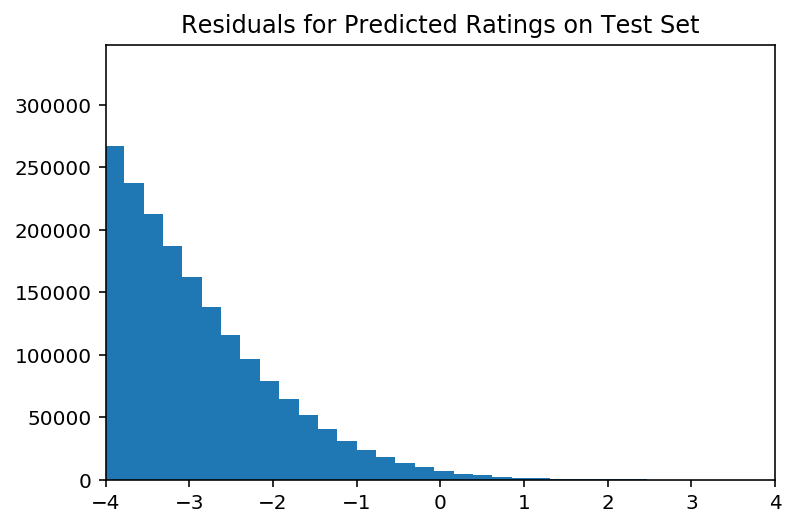

 50/400 [ 12%] ███                            ETA: 138s | Loss: 21957502.000 

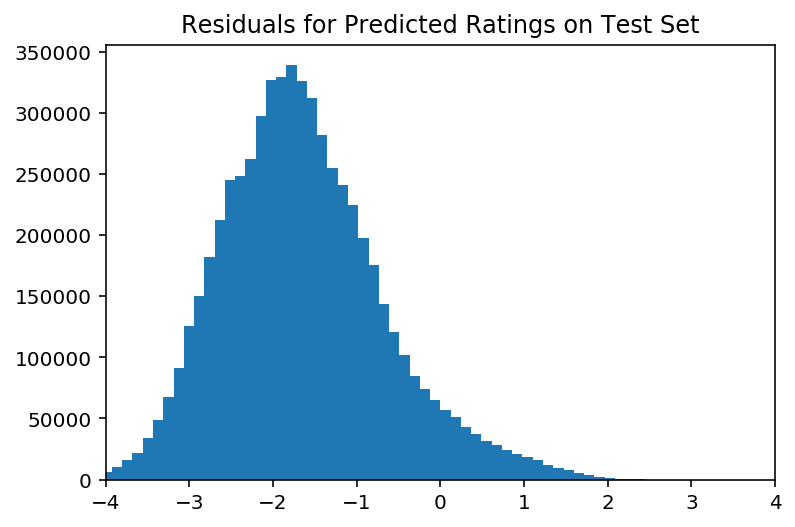

100/400 [ 25%] ███████                        ETA: 112s | Loss: 19218174.000

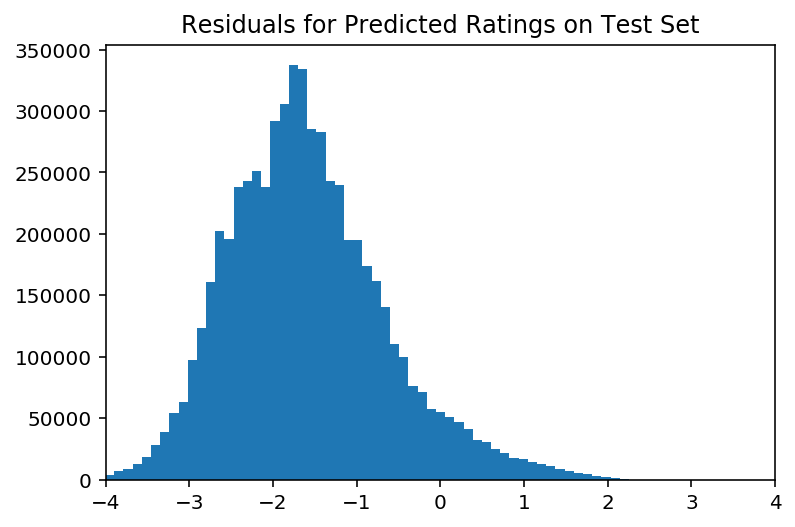

150/400 [ 37%] ███████████                    ETA: 91s | Loss: 18797472.000 

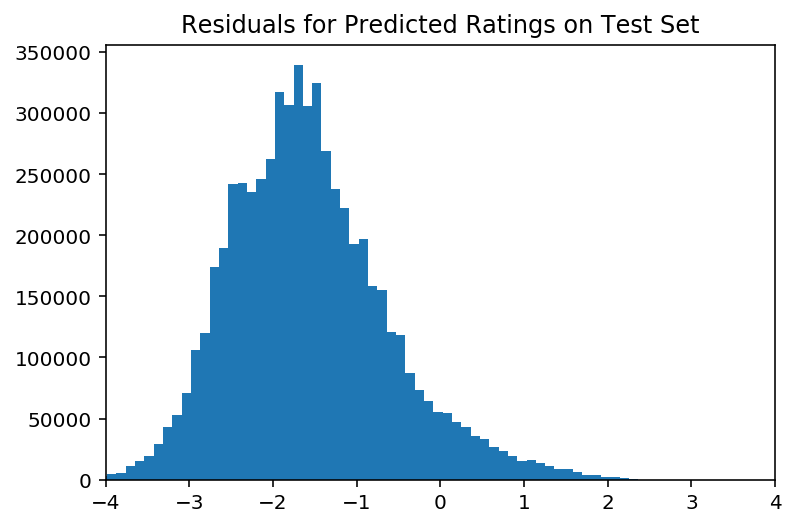

200/400 [ 50%] ███████████████                ETA: 73s | Loss: 18579544.000

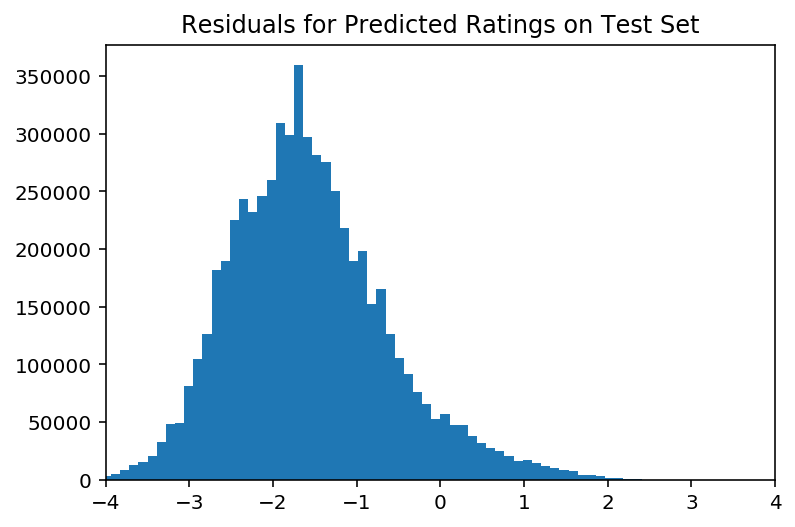

250/400 [ 62%] ██████████████████             ETA: 54s | Loss: 18499718.000

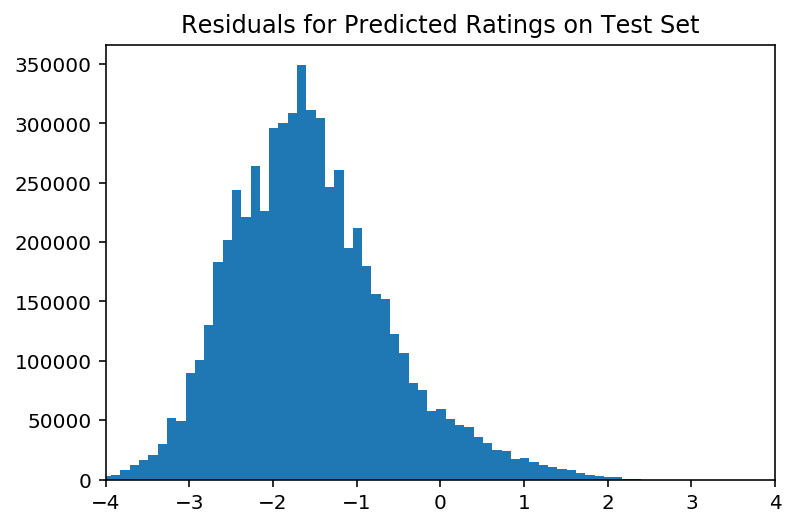

300/400 [ 75%] ██████████████████████         ETA: 36s | Loss: 18448910.000

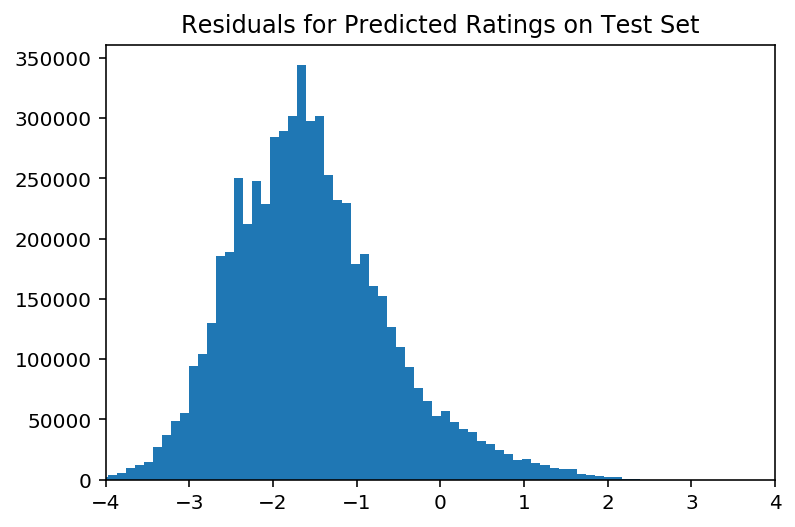

350/400 [ 87%] ██████████████████████████     ETA: 18s | Loss: 18402410.000

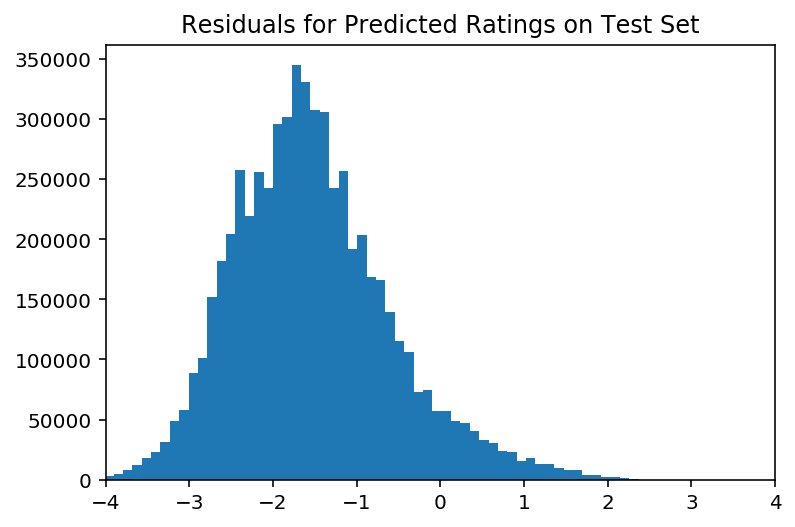

400/400 [100%] ██████████████████████████████ Elapsed: 144s | Loss: 18375746.000


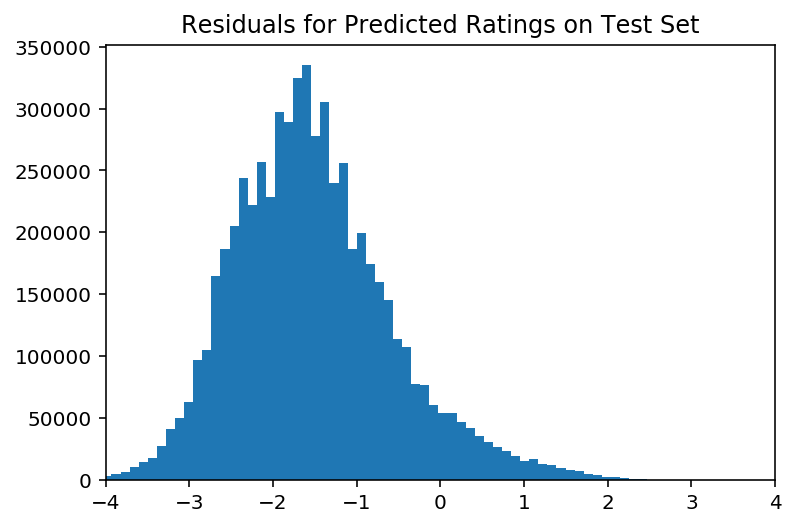

In [15]:
fit(plot=True)

In [16]:
%%time
fit(plot=False)

400/400 [100%] ██████████████████████████████ Elapsed: 147s | Loss: 18363540.000
CPU times: user 7min 33s, sys: 45.4 s, total: 8min 18s
Wall time: 2min 27s
